<a href="https://colab.research.google.com/github/maz-joko78/VTCI-LANDSAT-LC08-C02-T1_L2/blob/main/VTCI_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install numpy rasterio matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nilai maksimum LST: 94.45
Nilai minimum LST: -43.45
Nilai maksimum NDVI: 1.00
Nilai minimum NDVI: -1.00
Warm edge (LSTmax): LST = -23.8553 * NDVI + 72.1837
Cold edge (LSTmin): LST = 2.7530 * NDVI + 20.8416


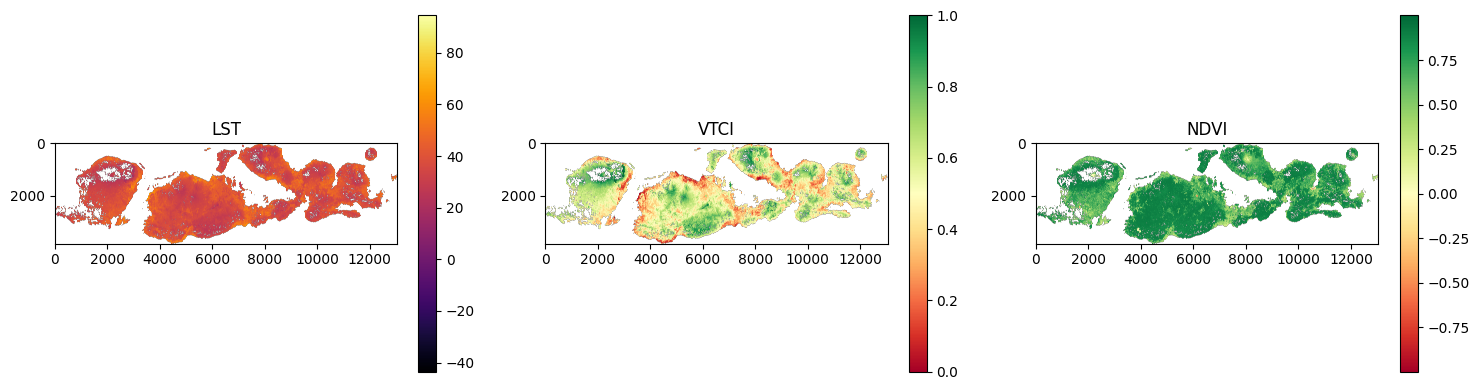

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


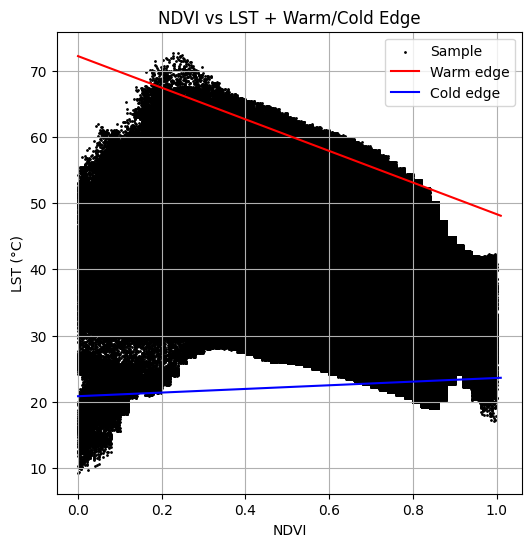

In [17]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

# Mount Google Drive to access the files
from google.colab import drive
drive.mount('/content/drive')

# =============================
# 1. Load LST dan NDVI
# =============================
lst_path = '/content/drive/MyDrive/1 LST_Matlab/LST_Bulan_1.tif'  # Verify this path is correct after mounting Google Drive.
ndvi_path = '/content/drive/MyDrive/1 LST_Matlab/NDVI_Bulan_1.tif'  # Verify this path is correct after mounting Google Drive.

with rasterio.open(lst_path) as src:
    lst = src.read(1)
    lst_meta = src.meta

with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1)

# Calculate max and min values using the loaded 'lst' and 'ndvi' variables
lst_max_value = np.nanmax(lst)
lst_min_value = np.nanmin(lst)

print(f"Nilai maksimum LST: {lst_max_value:.2f}")
print(f"Nilai minimum LST: {lst_min_value:.2f}")

ndvi_max_value = np.nanmax(ndvi)
ndvi_min_value = np.nanmin(ndvi)

print(f"Nilai maksimum NDVI: {ndvi_max_value:.2f}")
print(f"Nilai minimum NDVI: {ndvi_min_value:.2f}")

# =============================
# 2. Mask NaN atau nilai no-data
# =============================
mask = np.logical_and(~np.isnan(lst), ~np.isnan(ndvi))
lst = lst[mask]
ndvi = ndvi[mask]

# =============================
# 3. Binning NDVI dan filter outlier LST
# =============================
bin_edges = np.arange(0, 1.01, 0.02)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

lst_filtered = []
ndvi_filtered = []

for i in range(len(bin_edges) - 1):
    bin_mask = np.logical_and(ndvi >= bin_edges[i], ndvi < bin_edges[i+1])
    lst_bin = lst[bin_mask]
    ndvi_bin = ndvi[bin_mask]

    if len(lst_bin) > 10:
        median = np.median(lst_bin)
        std = np.std(lst_bin)
        lower = median - 3.0 * std
        upper = median + 3.0 * std
        inlier_mask = np.logical_and(lst_bin >= lower, lst_bin <= upper)

        lst_filtered.append(lst_bin[inlier_mask])
        ndvi_filtered.append(ndvi_bin[inlier_mask])

lst_filtered = np.concatenate(lst_filtered)
ndvi_filtered = np.concatenate(ndvi_filtered)

# =============================
# 4. Regressi Warm dan Cold Edge
# =============================
max_lst_per_bin = []
min_lst_per_bin = []
valid_bin = []

for i in range(len(bin_edges) - 1):
    bin_mask = np.logical_and(ndvi_filtered >= bin_edges[i], ndvi_filtered < bin_edges[i+1])
    lst_bin = lst_filtered[bin_mask]
    if len(lst_bin) > 0:
        max_lst_per_bin.append(np.max(lst_bin))
        min_lst_per_bin.append(np.min(lst_bin))
        valid_bin.append(bin_centers[i])

valid_bin = np.array(valid_bin).reshape(-1, 1)

warm_model = LinearRegression().fit(valid_bin, max_lst_per_bin)
cold_model = LinearRegression().fit(valid_bin, min_lst_per_bin)

warm_a, warm_b = warm_model.coef_[0], warm_model.intercept_
cold_a, cold_b = cold_model.coef_[0], cold_model.intercept_

print(f"Warm edge (LSTmax): LST = {warm_a:.4f} * NDVI + {warm_b:.4f}")
print(f"Cold edge (LSTmin): LST = {cold_a:.4f} * NDVI + {cold_b:.4f}")

# =============================
# 5. Hitung VTCI
# =============================
# Reload the full rasters for VTCI calculation
with rasterio.open(lst_path) as src:
    lst_full = src.read(1)
with rasterio.open(ndvi_path) as src:
    ndvi_full = src.read(1)


lst_max = warm_a * ndvi_full + warm_b
lst_min = cold_a * ndvi_full + cold_b

# Ganti NaN dengan 0
lst_full = np.nan_to_num(lst_full, nan=0)
ndvi_full = np.nan_to_num(ndvi_full, nan=0)
lst_max = np.nan_to_num(lst_max, nan=0)
lst_min = np.nan_to_num(lst_min, nan=0)

# Hindari pembagian dengan nol
denominator = lst_max - lst_min
denominator[denominator == 0] = 1e-10 # Ganti 0 dengan nilai kecil

vtci = (lst_max - lst_full) / denominator
vtci = np.clip(vtci, 0, 1)

# =============================
# 6. Visualisasi dengan Masking
# =============================

# 1. Buat mask berdasarkan data yang valid (non-NaN)
with rasterio.open(lst_path) as src:
    lst_full_viz = src.read(1) # Use a separate variable for visualization
    # Asumsikan nilai NoData adalah NaN
    mask = ~np.isnan(lst_full_viz)

# 2. Terapkan mask pada visualisasi
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
# Use masked array to apply the mask
masked_lst = np.ma.masked_array(lst_full_viz, ~mask)  # Mask invalid data
plt.imshow(masked_lst, cmap='inferno')
plt.title('LST')
plt.colorbar()

plt.subplot(1, 3, 2)
# Use masked array to apply the mask
masked_vtci = np.ma.masked_array(vtci, ~mask)  # Mask invalid data
plt.imshow(masked_vtci, cmap='RdYlGn')
plt.title('VTCI')
plt.colorbar()

plt.subplot(1, 3, 3)
# Need to reload ndvi_full for visualization after potential modifications
with rasterio.open(ndvi_path) as src:
    ndvi_full_viz = src.read(1)
# Use masked array to apply the mask
masked_ndvi = np.ma.masked_array(ndvi_full_viz, ~mask)  # Mask invalid data (using LST mask for consistency, assuming the masks are the same)
plt.imshow(masked_ndvi, cmap='RdYlGn')
plt.title('NDVI')
plt.colorbar()

plt.tight_layout()
plt.show()


# =============================
# 7. Scatter Plot NDVI vs LST + Regresi
# =============================
plt.figure(figsize=(6, 6))
plt.scatter(ndvi_filtered, lst_filtered, s=1, c='black', label='Sample')
ndvi_line = np.linspace(0, 1.01, 100)
plt.plot(ndvi_line, warm_a * ndvi_line + warm_b, 'r-', label='Warm edge')
plt.plot(ndvi_line, cold_a * ndvi_line + cold_b, 'b-', label='Cold edge')
plt.xlabel('NDVI')
plt.ylabel('LST (°C)')
plt.legend()
plt.title('NDVI vs LST + Warm/Cold Edge')
plt.grid(True)
plt.show()